In [2]:
import pickle
import numpy as np
import pandas as pd
from data_process import Get_Offense
from class_offfense import Offense
import distance_utils
import time
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
importlib.reload(distance_utils)
from distance_utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def get_data():
    with open('data/final_data.pkl', 'rb') as file:
        loaded_data = pickle.load(file)
    list_offense =[]
    for o in loaded_data:
        list_offense.append(Offense(o))

    return(list_offense)

In [4]:
list_offense = get_data()
len(list_offense)

67820

In [6]:
list_offense[0].end_location

[120.0, 35.2, 1.0]

In [12]:
max_time = -1
for o in list_offense:
    o.list_coords = o.list_coords[:8]
    o.list_action_type = o.list_action_type[:8]
    o.list_time = o.list_time[:8]
    m_time = o.list_time[-1]
    if m_time > max_time:
        max_time = m_time

max_time

[83.5, 32.7]
[81.0, 60.8]
[85.0, 37.8]
[86.8, 30.9]
[89.0, 48.5]
[88.8, 43.8]
[87.7, 48.3]
[75.9, 15.6]
[88.7, 38.7]
[85.6, 58.2]
[88.0, 38.9]
[89.1, 47.7]
[86.6, 43.2]
[89.4, 32.7]
[89.5, 43.0]
[87.7, 43.3]
[87.0, 63.0]
[89.6, 42.7]
[86.5, 44.0]
[83.7, 31.0]
[87.0, 29.1]
[85.5, 40.4]
[89.2, 52.1]
[85.1, 46.8]
[88.8, 40.6]
[88.1, 43.9]
[88.5, 43.2]
[87.2, 39.6]
[86.6, 39.4]
[89.4, 57.5]
[88.0, 31.0]
[84.0, 18.0]
[88.0, 53.0]
[89.0, 38.0]
[89.0, 56.0]
[86.0, 42.0]
[87.2, 31.4]
[89.0, 41.0]
[84.0, 40.1, 4.1]
[85.9, 37.0]
[88.0, 31.6]
[89.3, 42.4]
[86.2, 40.8]
[87.6, 44.4]
[88.7, 17.9]
[86.9, 50.1]
[88.3, 29.1]
[72.7, 59.6]
[88.0, 36.0]
[87.3, 39.9]
[87.2, 37.1]
[89.1, 32.7]
[88.2, 37.9]
[88.5, 31.5]
[87.9, 33.1]
[84.6, 52.8]
[75.0, 44.2]
[77.0, 60.4]
[89.1, 25.2]
[88.2, 43.7]
[87.6, 38.7]
[85.2, 46.6]
[88.8, 51.6]
[89.3, 35.9]
[75.5, 58.4]
[86.2, 35.1]
[89.8, 50.1]
[89.4, 43.7]
[87.7, 35.9]
[78.7, 48.6]
[83.8, 43.6]
[70.5, 52.0]
[88.2, 27.1]
[87.5, 45.3]
[86.3, 51.7]
[87.6, 41.2]
[87.0, 

248

# EDA

In [35]:
data = []

# Iterate through the list of Offense objects and extract the desired statistics
for offense in list_offense:
    if offense.list_coords[-1][0] < 60:
        d= offense.list_coords[-1][0]
    else:
        d = 120 - offense.list_coords[-1][0]
    c =0 
    p = 0
    dribble = 0
    for a in offense.list_action_type:
        if a == "Carry":
            c +=1
        elif a == "Pass":
            p += 1
        elif a == "Dribble":
            dribble += 1
    if offense.list_time[-1] < 0:
        s_t = 0
    else:
        s_t = offense.list_time[-1]
    data.append({
        'play_pattern': offense.play_pattern,
        'end_location': offense.end_location,
        'outcome': offense.outcome,
        'len_offense': len(offense.list_coords),
        'shot_distance': d,
        "carry" : c ,
        "pass" : p,
        "dribble" : dribble,
        'shot_time': s_t,
    })

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

In [36]:
df.head()

,play_pattern,end_location,outcome,len_offense,shot_distance,carry,pass,dribble,shot_time
0,Regular Play,"[120.0, 35.2, 1.0]",Off T,8,19.4,4,4,0,14
1,From Throw In,"[120.0, 39.3, 0.5]",Goal,4,9.1,1,2,0,6
2,From Throw In,"[118.1, 30.2]",Blocked,8,14.6,4,4,0,5
3,From Counter,"[120.0, 39.0, 0.2]",Goal,8,18.2,4,2,1,22
4,Regular Play,"[118.8, 36.0, 0.2]",Saved,8,41.6,3,5,0,14


In [37]:
df.to_csv('data/offense_eda.csv', index=False)


In [38]:
df.describe()

,len_offense,shot_distance,carry,pass,dribble,shot_time
count,67820.000000,67820.000000,67820.000000,67820.000000,67820.000000,67820.000000
mean,5.848422,25.318424,2.266912,2.851887,0.124491,9.286553
std,2.566860,15.619958,1.514360,1.661044,0.364206,7.243417
min,1.000000,-0.200000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,12.100000,1.000000,1.000000,0.000000,4.000000
50%,8.000000,22.500000,3.000000,3.000000,0.000000,9.000000
75%,8.000000,35.800000,4.000000,4.000000,0.000000,13.000000
max,8.000000,60.000000,5.000000,8.000000,4.000000,248.000000


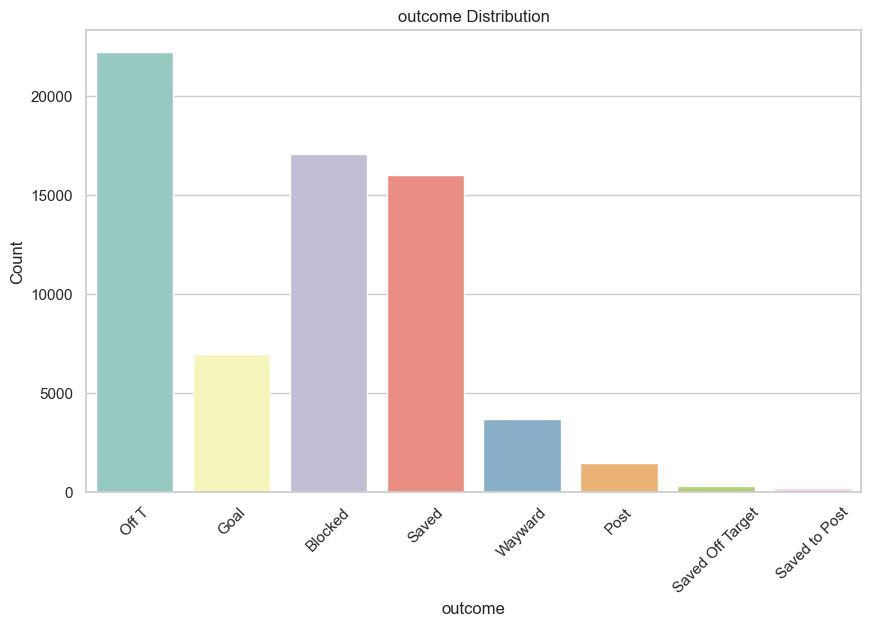

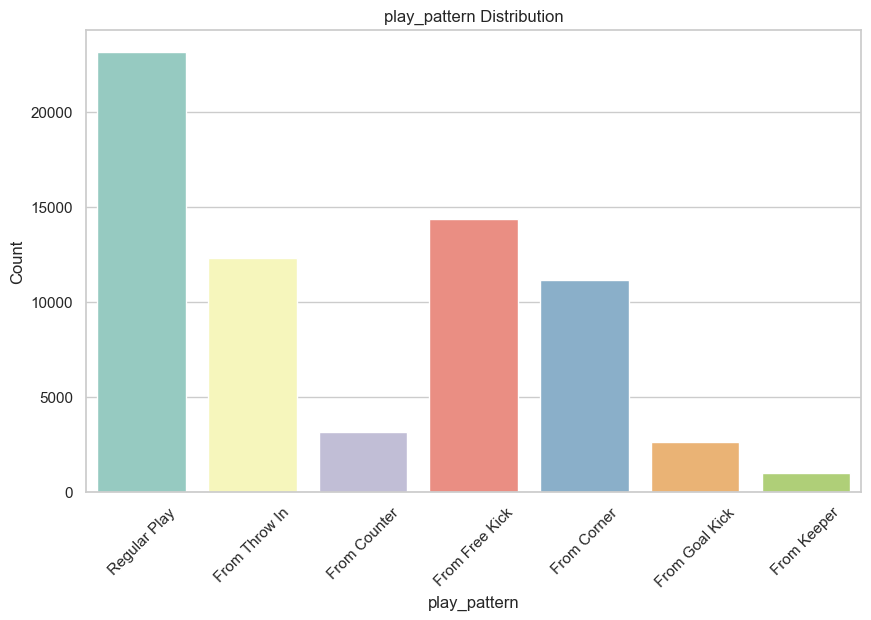

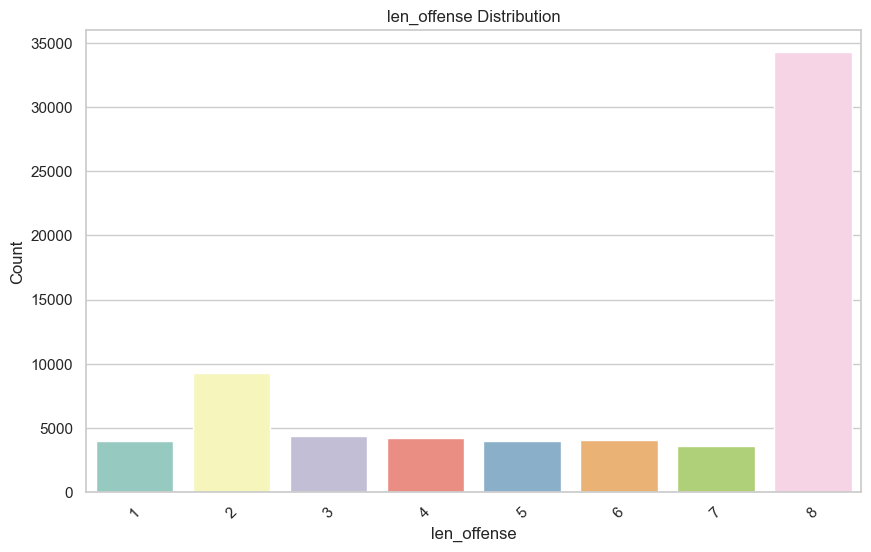

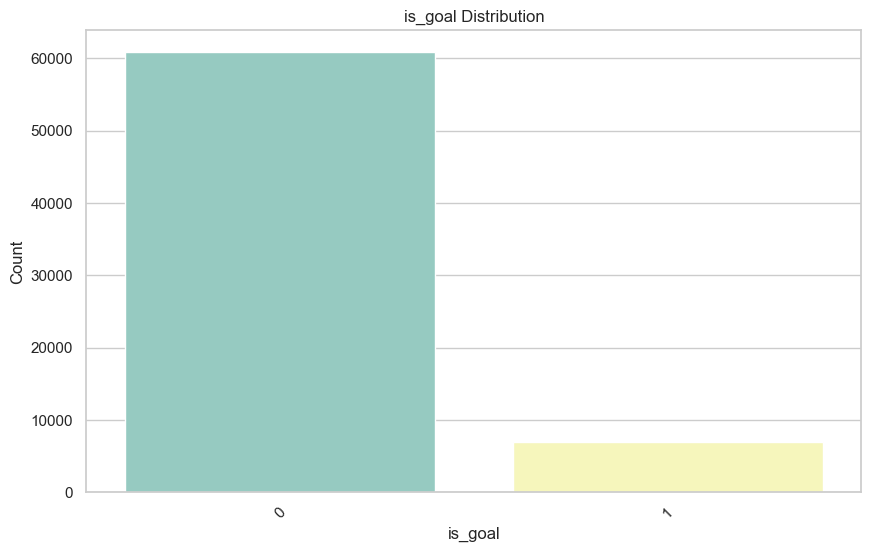

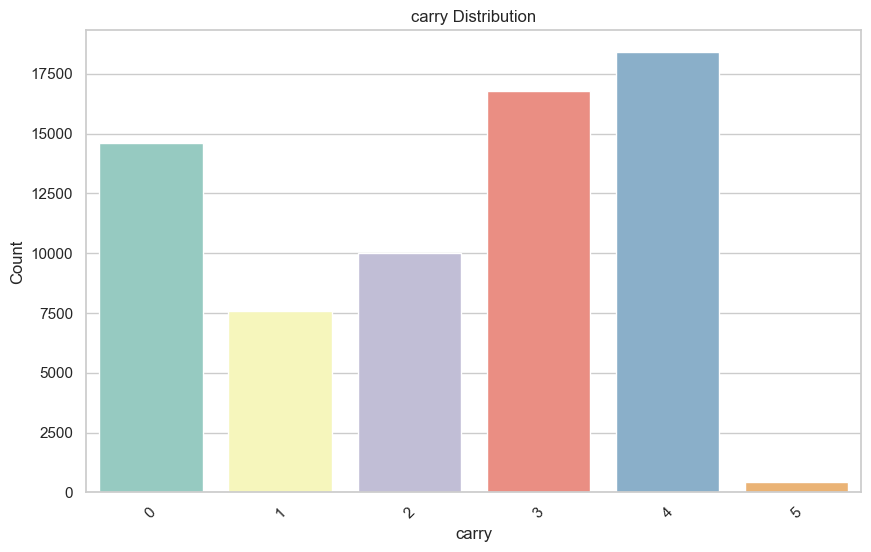

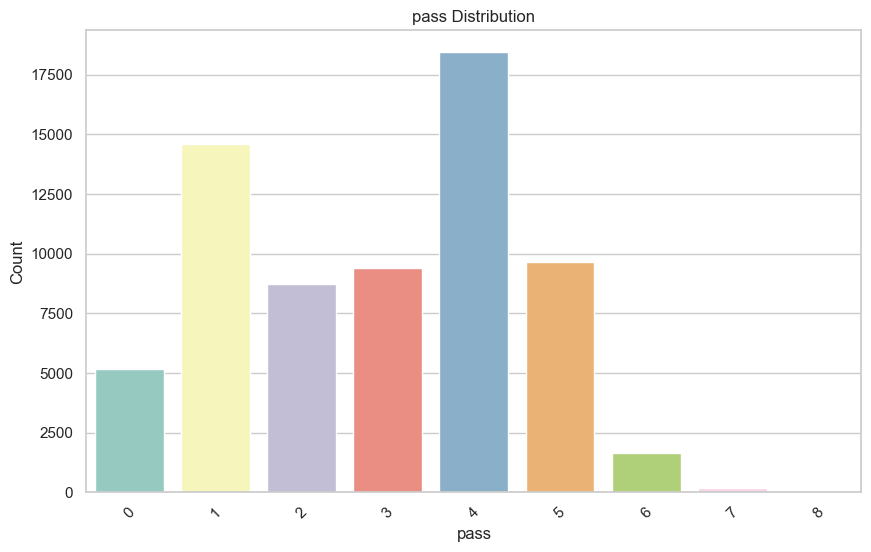

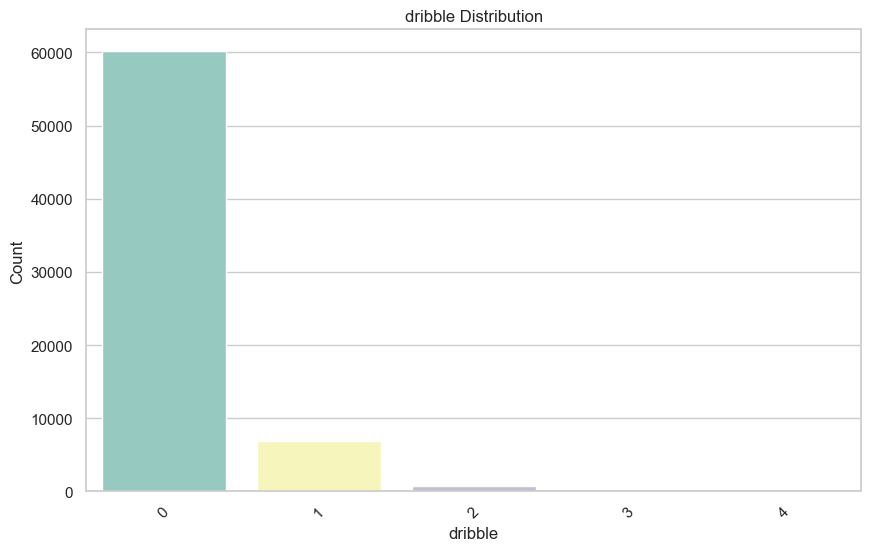

In [68]:
df['is_goal'] = df['outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
columns= ["outcome" , "play_pattern" , "len_offense" , "is_goal" , "carry",	"pass",	"dribble"]
for c in columns:
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create a bar plot for outcome distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=c, data=df, palette="Set3")
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.title(f'{c} Distribution')
    plt.xticks(rotation=45)
    plt.show()


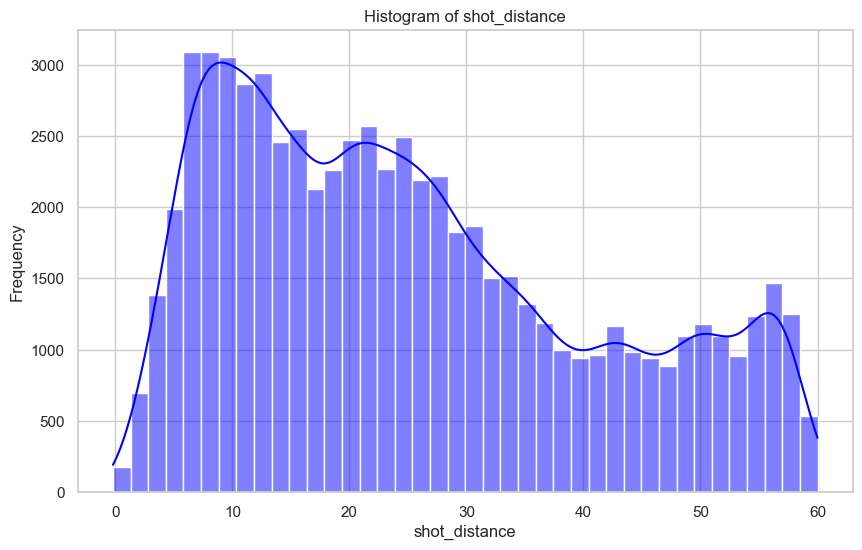

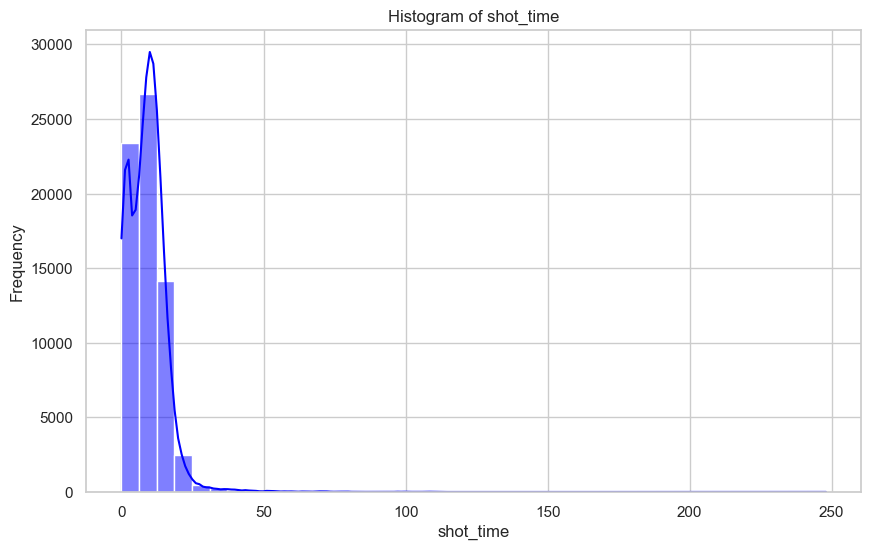

In [42]:
columns= ["shot_distance" , "shot_time" ]
for c in columns:  
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create a histogram for shot distance
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=c, bins=40, kde=True, color="blue")
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {c}')
    plt.show()

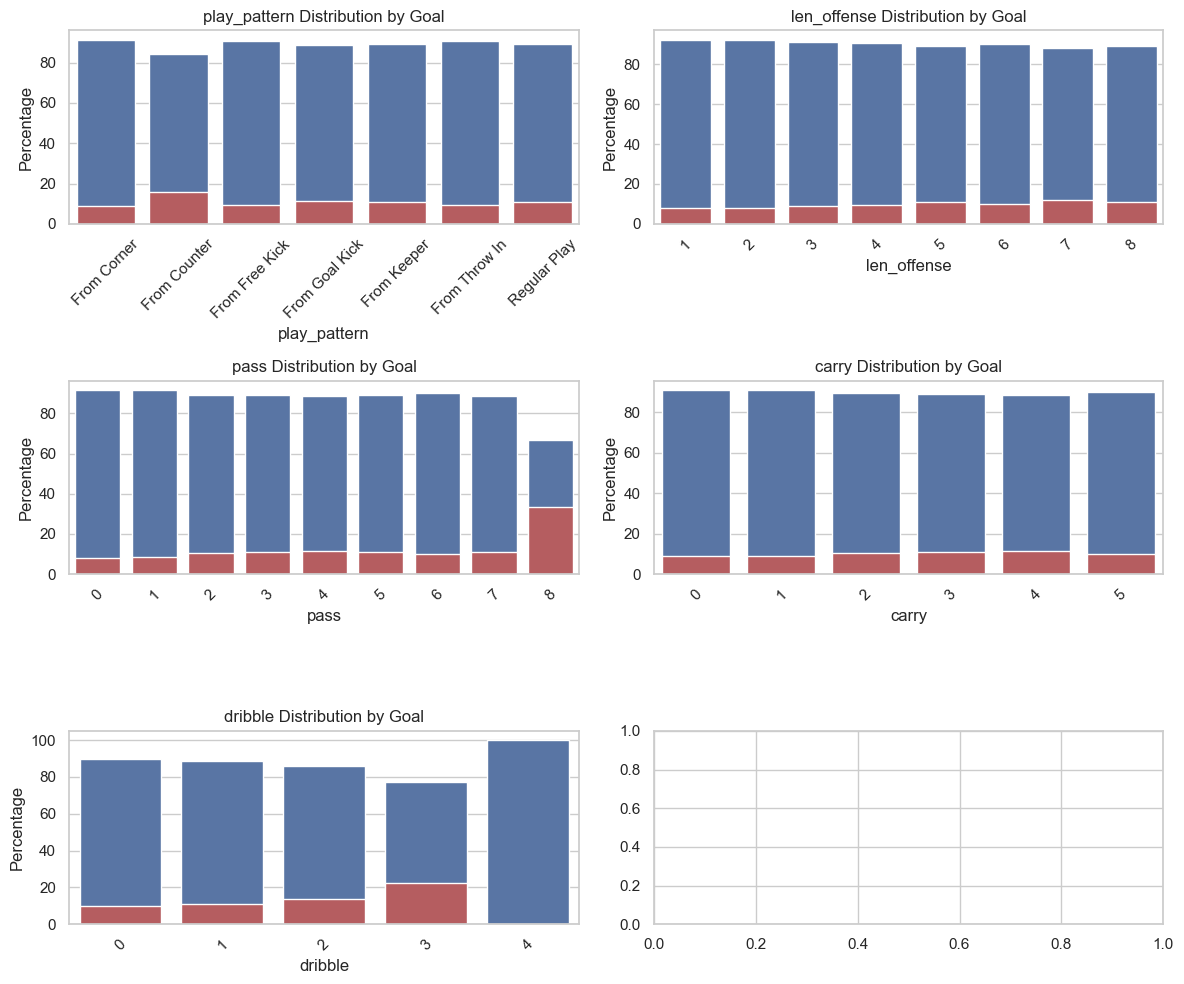

In [57]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
columns = ["play_pattern", "len_offense", "pass", "carry", "dribble"]
spots = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
for c, s in zip(columns, spots):
    # Calculate percentage values for each option within 'is_goal' groups
    percentages = df.groupby([c, 'is_goal']).size().unstack('is_goal').reset_index()
    percentages.fillna(0, inplace=True)
    total_per_option = percentages[0] + percentages[1]
    percentages[0] = (percentages[0] / total_per_option) * 100
    percentages[1] = (percentages[1] / total_per_option) * 100

    sns.barplot(x=c, y=0, data=percentages, ax=axes[s[0], s[1]], color='b', label='Goal')
    sns.barplot(x=c, y=1, data=percentages, ax=axes[s[0], s[1]], color='r', label='Not Goal')

    axes[s[0], s[1]].set_title(f'{c} Distribution by Goal')
    axes[s[0], s[1]].set_ylabel('Percentage')
    axes[s[0], s[1]].set_xlabel(c, ha='center')
        # Reformat x-axis labels to be horizontal
    for tick in axes[s[0], s[1]].get_xticklabels():
        tick.set_rotation(45)

# Adjust layout
plt.tight_layout()
plt.show()







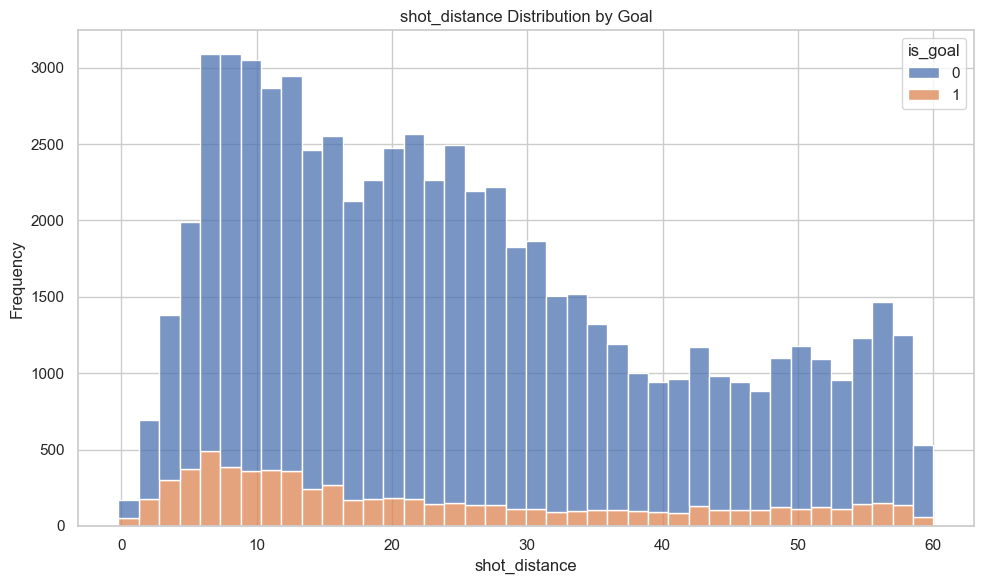

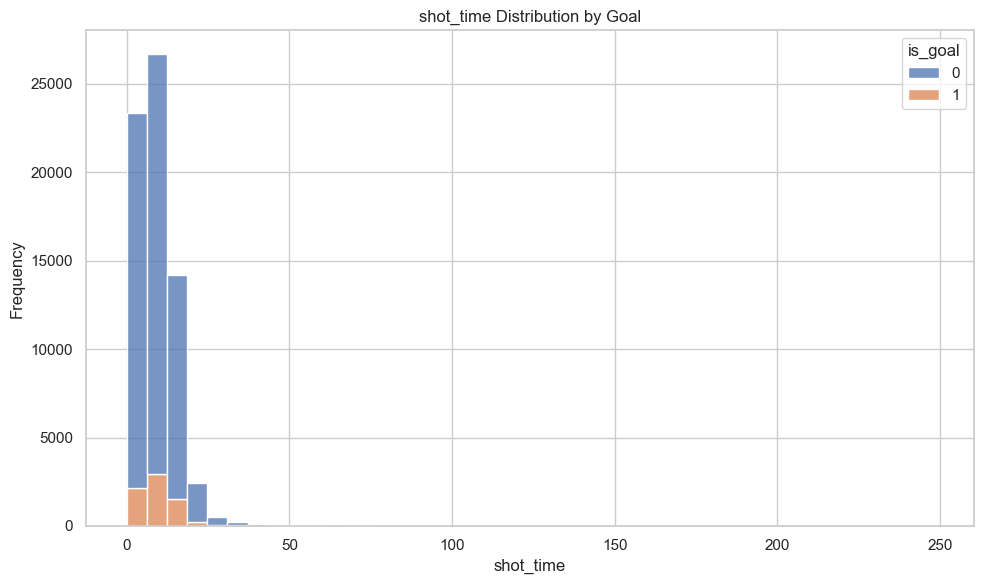

In [64]:
# Set the style of seaborn
sns.set(style="whitegrid")
columns = ["shot_distance" , "shot_time"]
for c in columns:
    # Plot histogram for "shot_distance"
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=c, hue='is_goal', multiple='stack', bins=40)

    plt.title(f'{c} Distribution by Goal')
    plt.ylabel('Frequency')
    plt.xlabel(c)
    plt.tick_params(axis='x', rotation=0)

    # Show the first histogram
    plt.tight_layout()
    plt.show()









# cluster


In [6]:
for i, offense in enumerate(list_offense):
    offense.index_in_current_list = i

print(list_offense[5].index_in_current_list)

5


# create distance metric

## DTW

In [ ]:
num_offenses = len(list_offense)
num_offenses = 6000
score_dict_dtw = {}
for i in tqdm(range(num_offenses), desc="Processing", ncols=100):
    score_dict_dtw[str(i)] = {}
    score_dict_dtw[str(i)][str(i)] = 0
    for j in range(i + 1, num_offenses):
        cost = DTW(list_offense[i], list_offense[j])
        score_dict_dtw[str(i)][str(j)] = cost
        
       

# Print the score_dict
print("Score Dictionary:")
print(score_dict_dtw)


In [8]:
score_dict_dtw.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])

In [ ]:
with open('data/Score_dtw(6000).json', 'w') as file:
    json.dump(score_dict_dtw, file, indent = 4)

In [9]:
def DTW_for_model(index1, index2):
    try:
        i1 = str(int(index1[0]))
        i2 = str(int(index2[0]))
    except:
        i1 = str(int(index1))
        i2 = str(int(index2))
    try:
        return score_dict_dtw[i1][i2]
    except:
        return score_dict_dtw[i2][i1]

In [10]:
all_index = [i for i in range(len(list_offense))]
all_index = [i for i in range(6000)]

global_centroid_dtw  = calculate_centroid(all_index , DTW_for_model)
global_centroid_dtw

95

## O3D

In [7]:
list_pcd = []
for offense in list_offense:
    list_pcd.append(create_pc(offense))



In [8]:
num_offenses = len(list_pcd)
#num_offenses = 10000
score_dict_o3d = {}
for i in tqdm(range(10000), desc="Processing", ncols=100):
    score_dict_o3d[str(i)] = {}
    score_dict_o3d[str(i)][str(i)] = 0
    for j in range(i + 1, num_offenses):
        cost = O3D(list_pcd[i], list_pcd[j])
        score_dict_o3d[str(i)][str(j)] = cost
            
       

# Print the score_dict
print("Score Dictionary:")
print(score_dict_o3d)

Processing:   4%|█▋                                          | 392/10000 [47:18<18:51:02,  7.06s/it]

: 

: 

In [ ]:
with open('data/Score_o3d.json', 'w') as file:
    json.dump(score_dict_o3d, file, indent = 4)

In [12]:
def O3D_for_model(index1, index2):
    try:
        i1 = str(int(index1[0]))
        i2 = str(int(index2[0]))
    except:
        i1 = str(int(index1))
        i2 = str(int(index2))
    try:
        return score_dict_o3d[i1][i2]
    except:
        return score_dict_o3d[i2][i1]

In [14]:
all_index = [i for i in range(len(list_offense))]
#all_index = [i for i in range(100)]

global_centroid_o3d = calculate_centroid(all_index , O3D_for_model)
global_centroid_o3d


95

# Clustering

## DBSCAN

In [102]:
from sklearn.cluster import DBSCAN


### TDW

In [266]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data_reshaped = data.reshape(-1, 1)
#data_reshaped = data_reshaped[:100]

eps_list = [0.01 , 0.02 ,0.03 , 0.04 , 0.05 , 0.06 , 0.07]
min_samples_list = [1,2,3,4,5,6,7,8]
results = []

for e in eps_list:
    for s in min_samples_list:
        dbscan = DBSCAN(metric= DTW_for_model, eps=e, min_samples=s)
        labels_per_index = dbscan.fit_predict(data_reshaped)
        labels_per_cluster = convert_to_clusters(labels_per_index)
        score = calculate_bcss_wcss_ratio(labels_per_cluster[:-1], DTW_for_model, global_centroid_dtw)
        outliers = len(labels_per_cluster[-1])
        num_clusters = len(labels_per_cluster) - 1
        
        # Append results to the list
        results.append({
            "Epsilon": e,
            "Min Samples": s,
            "Score": score,
            "Outliers": outliers,
            "Num Clusters": num_clusters
        })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)


'\nfor o, l in zip(list_offense, cluster_labels):\n    o.DBSCAN_DTW = l'

In [267]:
results_df

,Epsilon,Min Samples,Score,Outliers,Num Clusters
0,0.01,1,204.709297,0,86
1,0.01,2,60.402714,82,4
2,0.01,3,51.221290,86,2
3,0.01,4,60.850000,87,2
4,0.01,5,73.589084,91,1
5,0.01,6,73.589084,91,1
6,0.01,7,73.589084,91,1
7,0.02,1,68.488699,0,80
8,0.02,2,27.735152,74,6
9,0.02,3,31.103139,80,3


### O3D

In [276]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data_reshaped = data.reshape(-1, 1)
data_reshaped = data_reshaped[:100]

eps_list = [0.01 , 0.02 ,0.03 , 0.04 , 0.05 , 0.06 , 0.07]
min_samples_list = [1,2,3,4,5,6,7,8]
results = []

for e in eps_list:
    for s in min_samples_list:
        dbscan = DBSCAN(metric= O3D_for_model, eps=e, min_samples=s)
        labels_per_index = dbscan.fit_predict(data_reshaped)
        labels_per_cluster = convert_to_clusters(labels_per_index)
        score = calculate_bcss_wcss_ratio(labels_per_cluster[:-1], O3D_for_model, global_centroid_o3d)
        outliers = len(labels_per_cluster[-1])
        num_clusters = len(labels_per_cluster) - 1
        
        # Append results to the list
        results.append({
            "Epsilon": e,
            "Min Samples": s,
            "Score": score,
            "Outliers": outliers,
            "Num Clusters": num_clusters
        })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)


In [277]:
results_df

,Epsilon,Min Samples,Score,Outliers,Num Clusters
0,0.01,1,598.991526,0,95
1,0.01,2,71.512900,90,5
2,0.01,3,inf,100,0
3,0.01,4,inf,100,0
4,0.01,5,inf,100,0
5,0.01,6,inf,100,0
6,0.01,7,inf,100,0
7,0.01,8,inf,100,0
8,0.02,1,79.327989,0,86
9,0.02,2,19.658906,80,6


## K-means

## DTW

In [314]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data = data[:100]

max_iterations = 300
results = []
for n in range(4,15):
    n_clusters = n
    labels, centroids = custom_kmeans(data, n_clusters, max_iterations, DTW_for_model)
    label_mapping = {label: i for i, label in enumerate(centroids)}
    labels_per_index = [label_mapping[l] for l in labels]
    labels_per_cluster = convert_to_clusters(labels_per_index)
    score = calculate_bcss_wcss_ratio(labels_per_cluster, DTW_for_model, global_centroid_dtw)
    num_clusters = len(centroids) 
        
    # Append results to the list
    results.append({
        "Score": score,
        "Num Clusters": num_clusters
    })

results_df = pd.DataFrame(results)




[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [315]:
results_df

,Score,Num Clusters
0,1.945026,4
1,2.064881,5
2,2.288889,6
3,2.211113,7
4,2.273854,8
5,2.784905,9
6,2.482044,10
7,2.557306,11
8,2.940917,12
9,2.776421,13


## O3D

In [316]:
data = np.array([offense.index_in_current_list for offense in list_offense])
data = data[:100]

max_iterations = 300
results = []
for n in range(4,15):
    n_clusters = n
    labels, centroids = custom_kmeans(data, n_clusters, max_iterations, O3D_for_model)
    label_mapping = {label: i for i, label in enumerate(centroids)}
    labels_per_index = [label_mapping[l] for l in labels]
    labels_per_cluster = convert_to_clusters(labels_per_index)
    score = calculate_bcss_wcss_ratio(labels_per_cluster, O3D_for_model, global_centroid_o3d)
    num_clusters = len(centroids) 
        
    # Append results to the list
    results.append({
        "Score": score,
        "Num Clusters": num_clusters
    })

results_df = pd.DataFrame(results)

In [317]:
results_df

,Score,Num Clusters
0,1.802969,4
1,1.916403,5
2,1.664436,6
3,2.080446,7
4,2.159661,8
5,2.118849,9
6,2.206545,10
7,2.404682,11
8,2.321697,12
9,2.501543,13
